# 0.0. IMPORTS

In [54]:
import warnings

import pandas  as pd
import seaborn as sns
import random  as r

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt
from keras      import models          as ml
from keras      import layers          as l
from imblearn   import combine         as c
from imblearn   import over_sampling

In [55]:
warnings.filterwarnings("ignore")

## 0.1. Aux Functions

In [56]:
# jupyter design
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24

#     display(HTML('<style>.container { width:100% !important; }</style>'))
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.options.display.float_format = '{:,.4f}'.format
#     pd.set_option('display.expand_frame_repr', False)
#     pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

# imbalanced metrics ( balanced accuracy and kappa score )
def imbalanced_metrics( model_name, y_val, yhat ):
    # Balanced Accuracy
    balanced_accuracy = m.balanced_accuracy_score( y_val, yhat)
    
    # Kappa Score
    kappa_score = m.cohen_kappa_score( y_val, yhat )
    
    return pd.DataFrame({"balanced_accuracy": "{}".format(np.round(balanced_accuracy,3)),
                         "kappa_score": "{}".format(np.round(kappa_score,3))}, index=[model_name])

# cross validation neural networks
def cross_validation(model_name, model, x, y, epochs=100, verbose=0):
    
    balanced_accuracy_list = []
    kappa_score_list = []

    skf = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(x, y):
        
        x_train_cv = x.iloc[train_index]
        y_train_cv = y.iloc[train_index]
        
        x_test_cv = x.iloc[test_index]
        y_test_cv = y.iloc[test_index]
        
        # target variable encoding
        ohe = pp.OneHotEncoder()
        y_train_cv = ohe.fit_transform( y_train_cv.values.reshape( -1, 1 ) ).toarray()
        
        # model training
        model.fit(x_train_cv, y_train_cv, epochs=epochs, verbose=verbose )
        
        # prediction
        pred = model.predict(x_test_cv)
        yhat = ohe.inverse_transform( pred )
        
        # metrics
        balanced_accuracy_list.append( m.balanced_accuracy_score( y_test_cv, yhat) )
        kappa_score_list.append( m.cohen_kappa_score( y_test_cv, yhat ) )
        
    
    balanced_accuracy_mean, balanced_accuracy_std = np.round( np.mean( balanced_accuracy_list ), 2 ), np.round( np.std( balanced_accuracy_list ), 2 )
    kappa_score_mean, kappa_score_std = np.round( np.mean( kappa_score_list ), 2 ), np.round( np.std( kappa_score_list ), 2 )
   
    
    return pd.DataFrame({"Balanced_Accuracy:": "{} +/- {}".format(balanced_accuracy_mean, balanced_accuracy_std),
                         "Kappa_Score": "{} +/- {}".format(kappa_score_mean, kappa_score_std)}, index=[model_name])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Reading Data

In [57]:
df_raw = pd.read_csv( "../datasets/train_users_2.csv" )

# 1.0. DATA DESCRIPTION

In [58]:
df1 = df_raw.copy()

## 1.1. Columns Descriptions

In [59]:
df1.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

- **id:** user id

- **date_account_created:** the date of account creation

- **timestamp_first_active:** timestamp of the first activity, note that it can be earlier than date_account_created or -date_first_booking because a user can search before signing up

- **date_first_booking: date of first booking**

- **gender**

- **age**

- **signup_method**

- **signup_flow:** the page a user came to signup up from

- **language:** international language preference

- **affiliate_channel:** what kind of paid marketing

- **affiliate_provider:** where the marketing is e.g. google, craigslist, other

- **first_affiliate_tracked:** whats the first marketing the user interacted with before the signing up

- **signup_app**

- **first_device_type**

- **first_browser**

- **country_destination:** this is the target variable to predict

### 1.1.1. Rename Columns

No need, they're already on snakecase.

## 1.2. Data Dimensions

In [60]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


## 1.3. NA Check

In [61]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

### 1.3.1. NA Fulfill

In [62]:
# date first booking - max booking time
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )
df1['date_first_booking'] = df1['date_first_booking'].fillna( df1['date_first_booking'].max() )

# age - median age
df1 = df1[ (df1['age'] > 18) & (df1['age'] < 100) ]
df1['age'] = df1['age'].fillna( df1['age'].mean() )

# first affiliate tracked - drop
df1 = df1.dropna()

## 1.4. Data Types

In [63]:
df1.dtypes

id                                 object
date_account_created               object
timestamp_first_active              int64
date_first_booking         datetime64[ns]
gender                             object
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

### 1.4.1. Change types

In [64]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,20090523174809,2015-06-29,MALE,38.000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.000,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


In [65]:
# date account created - datetime
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp first active - datetime
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y-%m-%d %H:%M:%S' )

# age - int
df1['age'] = df1['age'].astype( 'int64' )

## 1.5. Data Proportion

In [66]:
df1['country_destination'].value_counts( normalize=True )

NDF     0.448
US      0.392
other   0.061
FR      0.030
IT      0.016
GB      0.014
ES      0.014
CA      0.009
DE      0.007
NL      0.005
AU      0.004
PT      0.001
Name: country_destination, dtype: float64

We clearly have Imbalanced Data, wich will affect the models.

## 1.6. Descriptive Statistics

In [67]:
df_num = df1[['age','signup_flow']]
df_cat = df1.select_dtypes( exclude=['int64','datetime64[ns]'] )

### 1.6.1. Numerical Attributes

In [68]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# central tendency - mean, median
ct1 = pd.DataFrame( df_num.apply( lambda x: np.mean( x ) ) ).T
ct2 = pd.DataFrame( df_num.apply( lambda x: np.median( x ) ) ).T

# dispersion metrics - min, max, range, std, skewness, kurtosis
dm1 = pd.DataFrame( df_num.apply( lambda x: np.min( x ) ) ).T
dm2 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) ) ).T
dm3 = pd.DataFrame( df_num.apply( lambda x: np.max( x ) - np.min( x ) ) ).T
dm4 = pd.DataFrame( df_num.apply( lambda x: np.std( x ) ) ).T
dm5 = pd.DataFrame( df_num.apply( lambda x: x.skew() ) ).T
dm6 = pd.DataFrame( df_num.apply( lambda x: x.kurtosis() ) ).T

# concat
df_description = pd.concat( [ dm1, dm2, dm3, ct1, ct2, dm4, dm5, dm6 ] ).T
df_description.columns = ( 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis' )
df_description

,min,max,range,mean,median,std,skewness,kurtosis
age,19.000,99.000,80.000,36.636,34.000,11.584,1.265,1.792
signup_flow,0.000,25.000,25.000,2.528,0.000,6.613,2.699,5.892


**Problems:**

- Age range ( filtered on NA fulfill )

### 1.6.2. Categorical Attributes

In [69]:
df_cat.drop( columns=['id'] ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,120307,120307,120307,120307,120307,120307,120307,120307,120307,120307
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,55595,64292,116000,77609,77472,63533,106154,56826,41035,53851


# 2.0. DATA FILTERING

In [70]:
df2 = df1.copy()

# 3.0. FEATURE ENGINEERING

In [71]:
df3 = df2.copy()

In [72]:
df3.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,1970-01-01 05:34:50.523174809,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,1970-01-01 05:34:50.609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,1970-01-01 05:34:51.031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,1970-01-01 05:34:51.208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,1970-01-01 05:35:00.102012558,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


In [73]:
# days timestamp first active to date account created
df3['date_first_active'] = pd.to_datetime( df3['timestamp_first_active'].dt.strftime('%Y-%m-%d') )
df3['timestamp_first_active_to_date_account_created'] = df3['date_account_created'] - df3['date_first_active']
df3['timestamp_first_active_to_date_account_created'] = df3['timestamp_first_active_to_date_account_created'].apply( lambda x: x.days )

# days timestamp first active to date first booking
df3['timestamp_first_active_to_date_first_booking'] = df3['date_first_booking'] - df3['date_first_active']
df3['timestamp_first_active_to_date_first_booking'] = df3['timestamp_first_active_to_date_first_booking'].apply( lambda x: x.days )

# days date account created to date first booking - CHECK NEGATIVE VALUES
df3['account_created_to_first_booking'] = df3['date_first_booking'] - df3['date_account_created']
df3['account_created_to_first_booking'] = df3['account_created_to_first_booking'].apply( lambda x: x.days )

# ================ first active ===================

# year
df3['year_date_first_active'] = df3['date_first_active'].dt.year

# month
df3['month_date_first_active'] = df3['date_first_active'].dt.month

# week
df3['week_date_first_active'] = df3['date_first_active'].dt.week

# day
df3['day_date_first_active'] = df3['date_first_active'].dt.day

# day_of_week
df3['day_of_week_date_first_active'] = df3['date_first_active'].dt.dayofweek

# ============ date account created ===============

# year
df3['year_date_account_created'] = df3['date_account_created'].dt.year

# month
df3['month_date_account_created'] = df3['date_account_created'].dt.month

# week
df3['week_date_account_created'] = df3['date_account_created'].dt.week

# day
df3['day_date_account_created'] = df3['date_account_created'].dt.day

# day_of_week
df3['day_of_week_date_account_created'] = df3['date_account_created'].dt.dayofweek

# ============= date first booking ================

# year
df3['year_date_first_booking'] = df3['date_first_booking'].dt.year

# month
df3['month_date_first_booking'] = df3['date_first_booking'].dt.month

# week
df3['week_date_first_booking'] = df3['date_first_booking'].dt.week

# day
df3['day_date_first_booking'] = df3['date_first_booking'].dt.day

# day_of_week
df3['day_of_week_date_first_booking'] = df3['date_first_booking'].dt.dayofweek

# 4.0. EXPLORATORY DATA ANALYSIS

In [74]:
df4 = df3.copy()

# 5.0. DATA PREPARATION

In [75]:
df5 = df4.drop( columns=['date_account_created','timestamp_first_active','date_first_booking','date_first_active'] )

df5_dummies = pd.get_dummies( df5.drop( columns=['id','country_destination'] ) )
df5 = pd.concat( [ df5[['id','country_destination']], df5_dummies ], axis=1 )

# 6.0. RESAMPLING

In [76]:
df_features = df5.drop( columns=['id','country_destination'] )
df_target = df5['country_destination'].copy()

## 6.1. SMOTETomek

In [77]:
# ratio_balanced =  {'NDF': 53851,
#                    'US':  47149,
#                    'other': 6*7511,
#                    'FR': 12*3669,
#                    'IT': 20*2014,
#                    'GB': 30*1758,
#                    'ES': 30*1685,
#                    'CA': 40*1064,
#                    'DE': 45*841,
#                    'NL': 80*595,
#                    'AU': 85*433,
#                    'PT': 300*157}

In [78]:
# # define
# smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# # apply
# features_smt, target_smt = smt.fit_resample( df_features, df_target )

## 6.2. SMOTE

In [79]:
ratio_balanced =  {'NDF': 53851,
                   'US':  47149,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}

In [80]:
# define
os = over_sampling.SMOTE( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply
features_smt, target_smt = os.fit_resample( df_features, df_target )

In [81]:
df5['country_destination'].value_counts()

NDF      53851
US       47149
other     7342
FR        3604
IT        1962
GB        1720
ES        1658
CA        1037
DE         820
NL         583
AU         425
PT         156
Name: country_destination, dtype: int64

In [82]:
target_smt.value_counts()

NDF      53851
GB       52740
ES       50550
NL       47600
US       47149
PT       47100
other    45066
FR       44028
CA       42560
IT       40280
DE       37845
AU       36805
Name: country_destination, dtype: int64

In [83]:
df6 = pd.concat( [features_smt, target_smt ], axis=1)
df6['id'] = df4['id'].copy()

# 7.0. FEATURE SELECTION

In [84]:
df7 = df6.copy()

# 8.0. MACHINE LEARNING

In [85]:
X = df7.drop( columns=['id','country_destination'] )
Y = df7['country_destination'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 8.1. Random Model

In [86]:
country_destination_list = df6['country_destination'].drop_duplicates().sort_values().to_list()
k = y_val.shape[0]
weights = df1['country_destination'].value_counts( normalize=True ).sort_index().to_list()

yhat_random = r.choices( population=country_destination_list,
                         weights=weights,
                         k=k )

### 8.1.1. Imbalanced Metrics and Confusion Matrix

In [87]:
imbalanced_metrics( 'Random Model', y_val, yhat_random )

,balanced_accuracy,kappa_score
Random Model,0.084,0.001


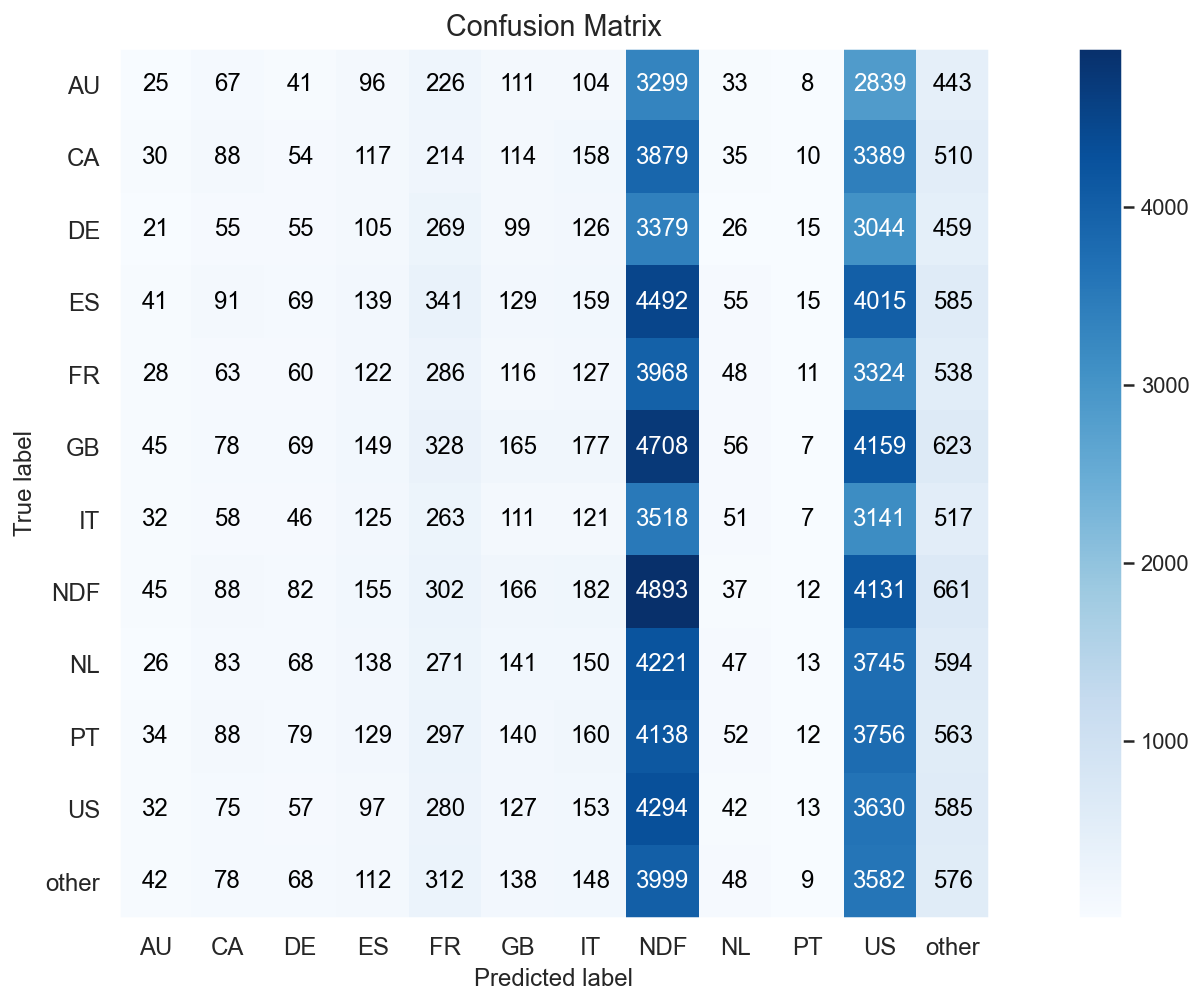

In [88]:
# Confusion Matrix
mt.plot_confusion_matrix( y_val, yhat_random, normalize=False );

## 8.2. Neural Network - MLP

In [89]:
# y train preparation
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [90]:
# model definition
model_nn = ml.Sequential()
model_nn.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
model_nn.add( l.Dense( 12, activation='softmax' ) )

# model compile
model_nn.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# model training
model_nn.fit( x_train, y_train_nn, epochs=100, verbose=0 )

In [95]:
# prediction
pred_nn = model_nn.predict( x_val )
yhat_nn = ohe.inverse_transform( pred_nn )

# # prediction prepare
# y_val_nn = y_val.to_numpy()
# yhat_nn = yhat_nn.reshape( 1, -1 )[0]

### 8.2.1. Imbalanced Metrics and Confusion Matrix

In [96]:
imbalanced_metrics( 'Neural Network', y_val, yhat_nn )

,balanced_accuracy,kappa_score
Neural Network,0.167,0.109


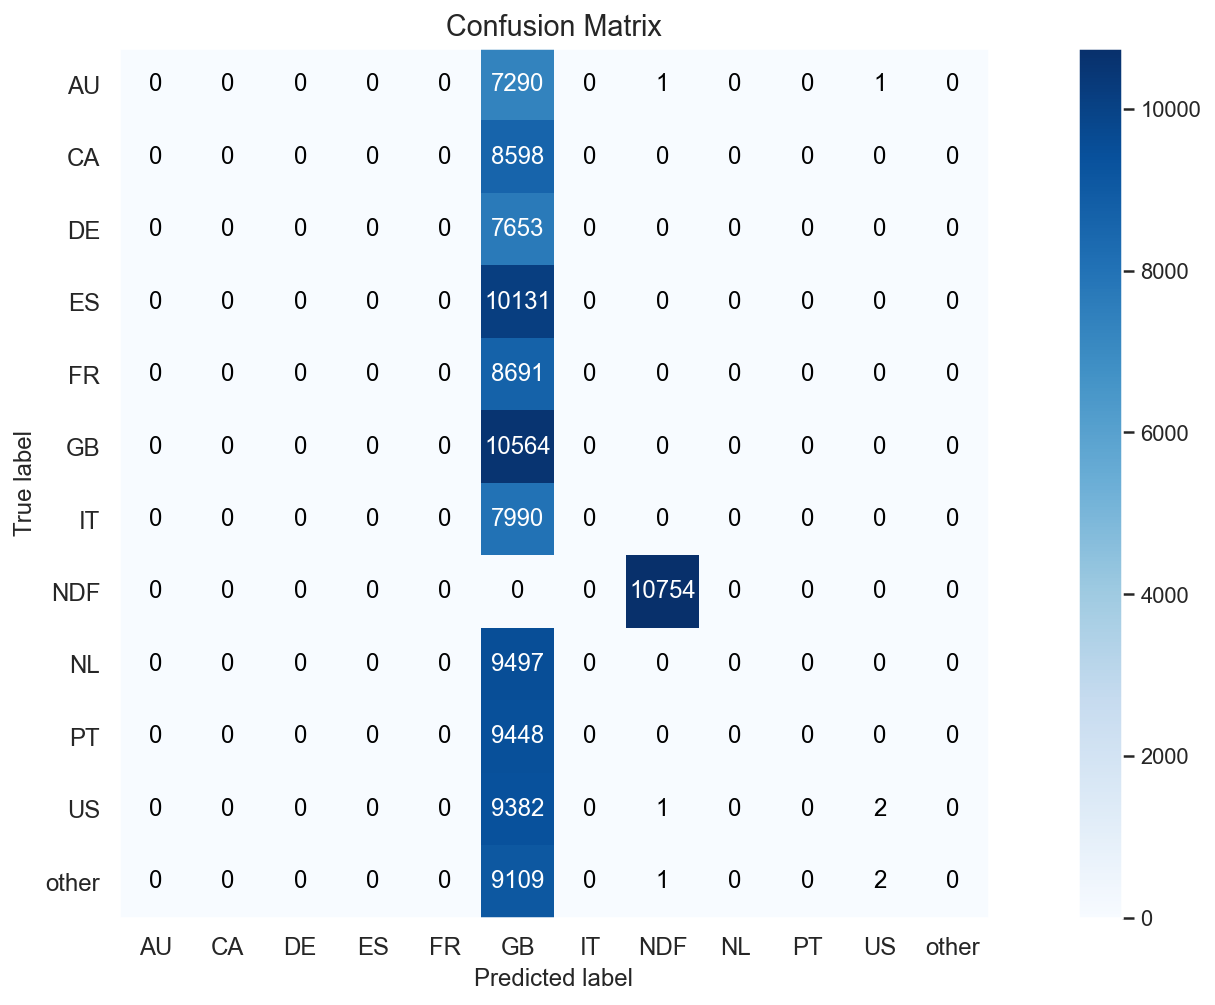

In [97]:
# Confusion Matrix
mt.plot_confusion_matrix( y_val, yhat_nn, normalize=False );

### 8.3. Cross Validation

In [94]:
# # cv
# cross_validation( "neural", model_nn, X, Y )

# 9.0. HYPERPARAMETER FINE TUNING

# 10.0. BUSINESS RESULTS

# 11.0. DEPLOY